## Capstone Project

## Machine Learning Model Development to Detect Black Hole Nodes in an AODV network.


This Jupyter Notebook script loaded the training and test datasets that were created from running NS-3 network simulations that simulated AODV networks with black hole nodes that disrupt communication by capturing network data and discarding it rather than passing it along to the correct destination node. 

The NS-3 simulation produced .pcap network traces for each node. all of these individual node trace files were imported into a script developed for this project that converted the AODV message observed in the nodes into a dataset with features that can be used to detect black hole nodes. These individual dataset were merged together into one large data set for each network simulation. 

**X amount of** simulations were merged together to form the training dataset and each additional network simulation can be used as a testing dataset. 

These models can be used to detect which nodes are acting as a black hole node within the network.

In [1]:
# Import packages that will be used in this project.
## Delete many of these
from IPython.display import Image
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

# from skimage.io import imread, imshow

from pathlib import Path
from glob import glob
import os

import seaborn as sns

import pickle

# Import the required modules.
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#from sklearn.decomposition import PCA
#from sklearn import preprocessing

import time

from sklearn.model_selection import cross_val_score,KFold

In [2]:
# Display all columns in the pd data frame
pd.set_option('display.max_columns', None)

## 1. Importing the datasets

The train and test .csv files are loaded.
As the data can be very easily produced from network simulations, data collection is not an issue and so the data is not split into training and test sets, instead the training and the test data are separate network simulations.

<span style="color: red;">Talk about the size of the training dataset, how many network sims combined?</span>
<span style="color: red;">How many sims should we use?</span>

In [3]:
# Read in the train and test sets
train =  pd.read_csv('./Datasets/train2_BHN.csv', index_col=0)
test = pd.read_csv('./Datasets/test3_BHN.csv', index_col=0)

In [4]:
train

,Index,Node,Nbr_Node,Nbr_Count,Hello_Cnt,AODV_Msg_Nbr_Cnt,RREQs_Sent_To_Nbr,RREQs_From_Nbr,Nbr_Is_Orig_Cnt,Nbr_Never_Orig,Nbr_Is_Dest_Cnt,Nbr_Never_Dest,All_RREPs_Rcvd_This_Node,RREPs_From_Nbr,RREP_Resp_Pct,Pct_Of_All_RREPs,Hop_Cnt_Over_1_Cnt,Hop_Cnt_Over_1_Pct,High_Dest_Seq_Num_Inc_Cnt,High_Dest_Seq_Num_Inc_Pct,Avg_Resp_Dly,Avg_Resp_Dly_Per_Hop,RERRs_From_Nbr,RERRs_From_Nbr_Pct,Pct_of_All_Nbrs,RREP_To_Nbrs_Ratio,Black_Hole_Node
0,1,10.1.1.0,10.1.1.45,44,25,0,181,0,0,True,0,True,621,0,0.000000,0.000000,0,NaN,0,NaN,NaN,NaN,0,NaN,2.27,0.000000,False
1,2,10.1.1.0,10.1.1.2,44,56,127,181,56,0,True,0,True,621,54,29.830000,8.695652,41,75.93,0,0.00,3.525608,0.946357,17,31.48,2.27,3.830684,False
2,3,10.1.1.0,10.1.1.1,44,151,262,181,149,5,False,0,True,621,69,38.120000,11.111111,31,44.93,0,0.00,1.826252,0.649025,44,63.77,2.27,4.894763,False
3,4,10.1.1.0,10.1.1.3,44,42,158,181,0,0,True,0,True,621,181,100.000000,29.146538,0,0.00,181,100.00,1.357565,0.553015,0,0.00,2.27,12.839885,True
4,5,10.1.1.0,10.1.1.31,44,24,49,181,24,0,True,0,True,621,15,8.287293,2.415459,8,53.33,0,0.00,0.502173,0.199722,10,66.67,2.27,1.064079,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,655,10.1.1.9,10.1.1.12,43,4,57,232,0,0,True,0,True,700,232,100.000000,33.142857,0,0.00,232,100.00,1.512891,0.189111,0,0.00,2.33,14.224402,True
655,656,10.1.1.9,10.1.1.19,43,7,128,232,73,10,False,0,True,700,27,11.637931,3.857143,27,100.00,1,3.70,2.992268,0.555514,28,103.70,2.33,1.655426,False
656,657,10.1.1.9,10.1.1.37,43,14,60,232,49,2,False,0,True,700,6,2.586207,0.857143,5,83.33,1,16.67,2.577405,0.236122,5,83.33,2.33,0.367872,False
657,658,10.1.1.9,10.1.1.41,43,15,148,232,49,0,True,0,True,700,46,19.827586,6.571429,33,71.74,0,0.00,2.455497,0.340709,53,115.22,2.33,2.820356,False


## 2. Exploring the Data

In [5]:
train.shape

(659, 27)

In [6]:
train.head()

,Index,Node,Nbr_Node,Nbr_Count,Hello_Cnt,AODV_Msg_Nbr_Cnt,RREQs_Sent_To_Nbr,RREQs_From_Nbr,Nbr_Is_Orig_Cnt,Nbr_Never_Orig,Nbr_Is_Dest_Cnt,Nbr_Never_Dest,All_RREPs_Rcvd_This_Node,RREPs_From_Nbr,RREP_Resp_Pct,Pct_Of_All_RREPs,Hop_Cnt_Over_1_Cnt,Hop_Cnt_Over_1_Pct,High_Dest_Seq_Num_Inc_Cnt,High_Dest_Seq_Num_Inc_Pct,Avg_Resp_Dly,Avg_Resp_Dly_Per_Hop,RERRs_From_Nbr,RERRs_From_Nbr_Pct,Pct_of_All_Nbrs,RREP_To_Nbrs_Ratio,Black_Hole_Node
0,1,10.1.1.0,10.1.1.45,44,25,0,181,0,0,True,0,True,621,0,0.000000,0.000000,0,NaN,0,NaN,NaN,NaN,0,NaN,2.27,0.000000,False
1,2,10.1.1.0,10.1.1.2,44,56,127,181,56,0,True,0,True,621,54,29.830000,8.695652,41,75.93,0,0.0,3.525608,0.946357,17,31.48,2.27,3.830684,False
2,3,10.1.1.0,10.1.1.1,44,151,262,181,149,5,False,0,True,621,69,38.120000,11.111111,31,44.93,0,0.0,1.826252,0.649025,44,63.77,2.27,4.894763,False
3,4,10.1.1.0,10.1.1.3,44,42,158,181,0,0,True,0,True,621,181,100.000000,29.146538,0,0.00,181,100.0,1.357565,0.553015,0,0.00,2.27,12.839885,True
4,5,10.1.1.0,10.1.1.31,44,24,49,181,24,0,True,0,True,621,15,8.287293,2.415459,8,53.33,0,0.0,0.502173,0.199722,10,66.67,2.27,1.064079,False


The datasets contain 29 features of which the last feature 'Black_Hole_Node' is the target variable. If it is flagged as True, the 1st tier neighbour node 'Nbr_Node' is a black hole node. 

In [7]:
test.head()

,Index,Node,Nbr_Node,Nbr_Count,Hello_Cnt,AODV_Msg_Nbr_Cnt,RREQs_Sent_To_Nbr,RREQs_From_Nbr,Nbr_Is_Orig_Cnt,Nbr_Never_Orig,Nbr_Is_Dest_Cnt,Nbr_Never_Dest,All_RREPs_Rcvd_This_Node,RREPs_From_Nbr,RREP_Resp_Pct,Pct_Of_All_RREPs,Hop_Cnt_Over_1_Cnt,Hop_Cnt_Over_1_Pct,High_Dest_Seq_Num_Inc_Cnt,High_Dest_Seq_Num_Inc_Pct,Avg_Resp_Dly,Avg_Resp_Dly_Per_Hop,RERRs_From_Nbr,RERRs_From_Nbr_Pct,Pct_of_All_Nbrs,RREP_To_Nbrs_Ratio,Black_Hole_Node
0,1,10.1.1.40,10.1.1.37,37,12,46,261,37,1,False,0,True,733,5,1.92,0.68,5,100.00,0,0.0,4.743225,0.458547,4,80.00,2.7,0.251852,False
1,2,10.1.1.40,10.1.1.3,37,19,0,261,0,0,True,0,True,733,0,0.00,0.00,0,NaN,0,NaN,NaN,NaN,0,NaN,2.7,0.000000,False
2,3,10.1.1.40,10.1.1.5,37,41,34,261,18,0,True,0,True,733,14,5.36,1.91,14,100.00,0,0.0,3.986430,0.619930,2,14.29,2.7,0.707407,False
3,4,10.1.1.40,10.1.1.12,37,62,171,261,138,34,False,0,True,733,18,6.90,2.46,17,94.44,0,0.0,3.605955,0.588845,15,83.33,2.7,0.911111,False
4,5,10.1.1.40,10.1.1.41,37,133,433,261,239,1,False,0,True,733,112,42.91,15.28,89,79.46,0,0.0,2.620496,0.412112,82,73.21,2.7,5.659259,False


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 0 to 658
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Index                      659 non-null    int64  
 1   Node                       659 non-null    object 
 2   Nbr_Node                   659 non-null    object 
 3   Nbr_Count                  659 non-null    int64  
 4   Hello_Cnt                  659 non-null    int64  
 5   AODV_Msg_Nbr_Cnt           659 non-null    int64  
 6   RREQs_Sent_To_Nbr          659 non-null    int64  
 7   RREQs_From_Nbr             659 non-null    int64  
 8   Nbr_Is_Orig_Cnt            659 non-null    int64  
 9   Nbr_Never_Orig             659 non-null    bool   
 10  Nbr_Is_Dest_Cnt            659 non-null    int64  
 11  Nbr_Never_Dest             659 non-null    bool   
 12  All_RREPs_Rcvd_This_Node   659 non-null    int64  
 13  RREPs_From_Nbr             659 non-null    int64  

In [9]:
# Convert the boolean values to 1 or 0 for the training set.
train.Nbr_Never_Orig = train.Nbr_Never_Orig.replace( {True: 1, False: 0})
train.Nbr_Never_Dest = train.Nbr_Never_Dest.replace( {True: 1, False: 0})
train.Black_Hole_Node = train.Black_Hole_Node.replace( {True: 1, False: 0})

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 0 to 658
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Index                      659 non-null    int64  
 1   Node                       659 non-null    object 
 2   Nbr_Node                   659 non-null    object 
 3   Nbr_Count                  659 non-null    int64  
 4   Hello_Cnt                  659 non-null    int64  
 5   AODV_Msg_Nbr_Cnt           659 non-null    int64  
 6   RREQs_Sent_To_Nbr          659 non-null    int64  
 7   RREQs_From_Nbr             659 non-null    int64  
 8   Nbr_Is_Orig_Cnt            659 non-null    int64  
 9   Nbr_Never_Orig             659 non-null    int64  
 10  Nbr_Is_Dest_Cnt            659 non-null    int64  
 11  Nbr_Never_Dest             659 non-null    int64  
 12  All_RREPs_Rcvd_This_Node   659 non-null    int64  
 13  RREPs_From_Nbr             659 non-null    int64  

In [11]:
# Convert the boolean values to 1 or 0 for the test set.
test.Nbr_Never_Orig = test.Nbr_Never_Orig.replace( {True: 1, False: 0})
test.Nbr_Never_Dest = test.Nbr_Never_Dest.replace( {True: 1, False: 0})
test.Black_Hole_Node = test.Black_Hole_Node.replace( {True: 1, False: 0})

In [12]:
# Check for null values.
print(f'Null Values\n {train.isnull().sum()}')

Null Values
 Index                          0
Node                           0
Nbr_Node                       0
Nbr_Count                      0
Hello_Cnt                      0
AODV_Msg_Nbr_Cnt               0
RREQs_Sent_To_Nbr              0
RREQs_From_Nbr                 0
Nbr_Is_Orig_Cnt                0
Nbr_Never_Orig                 0
Nbr_Is_Dest_Cnt                0
Nbr_Never_Dest                 0
All_RREPs_Rcvd_This_Node       0
RREPs_From_Nbr                 0
RREP_Resp_Pct                  0
Pct_Of_All_RREPs               0
Hop_Cnt_Over_1_Cnt             0
Hop_Cnt_Over_1_Pct           235
High_Dest_Seq_Num_Inc_Cnt      0
High_Dest_Seq_Num_Inc_Pct    235
Avg_Resp_Dly                 246
Avg_Resp_Dly_Per_Hop         246
RERRs_From_Nbr                 0
RERRs_From_Nbr_Pct           235
Pct_of_All_Nbrs                0
RREP_To_Nbrs_Ratio             0
Black_Hole_Node                0
dtype: int64


Observing the features above, many have missing values. This can be explained by the fact that many 1st tier neighbours of the subject node were not initiating RREQ messages or they were not the destination. This would result in RREPs_From_Nbr = 0. This feature was often used as a divisor for calculating percentages and so this would result in NA fields that were left blank when the dataset creation script was run. These are not really missing values but rather truly non applicable fields. For the machine learning to continue, these rows will be deleted so that there are no missing values. 

It is expected that a black hole node would also respond to an RREP request with a short hop count, so neighbours that don't respond to RREQ requests are not likely to be malicious.

Importantly, there are no missing values in the target variable 'Black_Hole_Node'.

In [13]:
# Check for null values.
print(f'Null Values\n {test.isnull().sum()}')

Null Values
 Index                          0
Node                           0
Nbr_Node                       0
Nbr_Count                      0
Hello_Cnt                      0
AODV_Msg_Nbr_Cnt               0
RREQs_Sent_To_Nbr              0
RREQs_From_Nbr                 0
Nbr_Is_Orig_Cnt                0
Nbr_Never_Orig                 0
Nbr_Is_Dest_Cnt                0
Nbr_Never_Dest                 0
All_RREPs_Rcvd_This_Node       0
RREPs_From_Nbr                 0
RREP_Resp_Pct                  0
Pct_Of_All_RREPs               0
Hop_Cnt_Over_1_Cnt             0
Hop_Cnt_Over_1_Pct           158
High_Dest_Seq_Num_Inc_Cnt      0
High_Dest_Seq_Num_Inc_Pct    158
Avg_Resp_Dly                 164
Avg_Resp_Dly_Per_Hop         164
RERRs_From_Nbr                 0
RERRs_From_Nbr_Pct           158
Pct_of_All_Nbrs                0
RREP_To_Nbrs_Ratio             0
Black_Hole_Node                0
dtype: int64


The same is true for the test dataset.

Remove the rows with missing values.

In [14]:
train = train.dropna().reset_index(drop=True)
test = test.dropna().reset_index(drop=True)

In [15]:
train.head(10)

,Index,Node,Nbr_Node,Nbr_Count,Hello_Cnt,AODV_Msg_Nbr_Cnt,RREQs_Sent_To_Nbr,RREQs_From_Nbr,Nbr_Is_Orig_Cnt,Nbr_Never_Orig,Nbr_Is_Dest_Cnt,Nbr_Never_Dest,All_RREPs_Rcvd_This_Node,RREPs_From_Nbr,RREP_Resp_Pct,Pct_Of_All_RREPs,Hop_Cnt_Over_1_Cnt,Hop_Cnt_Over_1_Pct,High_Dest_Seq_Num_Inc_Cnt,High_Dest_Seq_Num_Inc_Pct,Avg_Resp_Dly,Avg_Resp_Dly_Per_Hop,RERRs_From_Nbr,RERRs_From_Nbr_Pct,Pct_of_All_Nbrs,RREP_To_Nbrs_Ratio,Black_Hole_Node
0,2,10.1.1.0,10.1.1.2,44,56,127,181,56,0,1,0,1,621,54,29.830000,8.695652,41,75.93,0,0.0,3.525608,0.946357,17,31.48,2.27,3.830684,0
1,3,10.1.1.0,10.1.1.1,44,151,262,181,149,5,0,0,1,621,69,38.120000,11.111111,31,44.93,0,0.0,1.826252,0.649025,44,63.77,2.27,4.894763,0
2,4,10.1.1.0,10.1.1.3,44,42,158,181,0,0,1,0,1,621,181,100.000000,29.146538,0,0.00,181,100.0,1.357565,0.553015,0,0.00,2.27,12.839885,1
3,5,10.1.1.0,10.1.1.31,44,24,49,181,24,0,1,0,1,621,15,8.287293,2.415459,8,53.33,0,0.0,0.502173,0.199722,10,66.67,2.27,1.064079,0
4,10,10.1.1.0,10.1.1.18,44,30,20,181,14,10,0,0,1,621,3,1.657459,0.483092,1,33.33,0,0.0,0.956295,0.407157,3,100.00,2.27,0.212816,0
5,14,10.1.1.0,10.1.1.43,44,14,12,181,7,0,1,0,1,621,3,1.657459,0.483092,2,66.67,0,0.0,0.012493,0.005030,2,66.67,2.27,0.212816,0
6,16,10.1.1.0,10.1.1.37,44,28,24,181,10,1,0,0,1,621,11,6.077348,1.771337,10,90.91,0,0.0,2.379127,0.635758,3,27.27,2.27,0.780324,0
7,17,10.1.1.0,10.1.1.6,44,20,79,181,41,1,0,0,1,621,29,16.022099,4.669887,13,44.83,0,0.0,3.044343,1.182209,9,31.03,2.27,2.057219,0
8,18,10.1.1.0,10.1.1.8,44,26,32,181,19,0,1,0,1,621,10,5.524862,1.610306,7,70.00,0,0.0,2.760390,0.858879,3,30.00,2.27,0.709386,0
9,20,10.1.1.0,10.1.1.5,44,7,27,181,11,1,0,0,1,621,13,7.182320,2.093398,6,46.15,0,0.0,0.977783,0.339244,3,23.08,2.27,0.922202,0


In [16]:
# Confirm there are no null values in the train dataset.
print(f'Null Values\n {train.isnull().sum()}')

Null Values
 Index                        0
Node                         0
Nbr_Node                     0
Nbr_Count                    0
Hello_Cnt                    0
AODV_Msg_Nbr_Cnt             0
RREQs_Sent_To_Nbr            0
RREQs_From_Nbr               0
Nbr_Is_Orig_Cnt              0
Nbr_Never_Orig               0
Nbr_Is_Dest_Cnt              0
Nbr_Never_Dest               0
All_RREPs_Rcvd_This_Node     0
RREPs_From_Nbr               0
RREP_Resp_Pct                0
Pct_Of_All_RREPs             0
Hop_Cnt_Over_1_Cnt           0
Hop_Cnt_Over_1_Pct           0
High_Dest_Seq_Num_Inc_Cnt    0
High_Dest_Seq_Num_Inc_Pct    0
Avg_Resp_Dly                 0
Avg_Resp_Dly_Per_Hop         0
RERRs_From_Nbr               0
RERRs_From_Nbr_Pct           0
Pct_of_All_Nbrs              0
RREP_To_Nbrs_Ratio           0
Black_Hole_Node              0
dtype: int64


In [17]:
train.shape

(413, 27)

In [18]:
test.shape

(214, 27)

The train and test sets now have no missing values and the modelling can proceed.

**Display the descriptive statistics of the AODV network dataset**

In [19]:
train.describe()

,Index,Nbr_Count,Hello_Cnt,AODV_Msg_Nbr_Cnt,RREQs_Sent_To_Nbr,RREQs_From_Nbr,Nbr_Is_Orig_Cnt,Nbr_Never_Orig,Nbr_Is_Dest_Cnt,Nbr_Never_Dest,All_RREPs_Rcvd_This_Node,RREPs_From_Nbr,RREP_Resp_Pct,Pct_Of_All_RREPs,Hop_Cnt_Over_1_Cnt,Hop_Cnt_Over_1_Pct,High_Dest_Seq_Num_Inc_Cnt,High_Dest_Seq_Num_Inc_Pct,Avg_Resp_Dly,Avg_Resp_Dly_Per_Hop,RERRs_From_Nbr,RERRs_From_Nbr_Pct,Pct_of_All_Nbrs,RREP_To_Nbrs_Ratio,Black_Hole_Node
count,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.0,413.0,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.00000,413.000000,413.000000,413.000000
mean,327.559322,42.041162,27.343826,83.135593,203.566586,38.138015,2.878935,0.578692,0.0,1.0,664.506053,37.627119,18.431124,6.122132,17.416465,63.550097,14.929782,7.326707,2.369314,0.577705,16.239709,96.05632,2.422082,2.487258,0.072639
std,184.978822,5.328596,29.512675,78.312115,50.183291,41.727535,7.678925,0.494368,0.0,0.0,270.516412,55.452564,26.034555,9.769391,22.769122,33.297773,54.980115,25.982626,1.212304,0.345443,16.727780,116.84963,0.344512,3.745815,0.259858
min,2.000000,31.000000,0.000000,3.000000,106.000000,0.000000,0.000000,0.000000,0.0,1.0,159.000000,1.000000,0.371747,0.103093,0.000000,0.000000,0.000000,0.000000,0.002137,0.001069,0.000000,0.00000,2.040000,0.042251,0.000000
25%,168.000000,41.000000,9.000000,32.000000,178.000000,14.000000,0.000000,0.000000,0.0,1.0,451.000000,7.000000,3.555556,1.226994,2.000000,43.480000,0.000000,0.000000,1.512891,0.381957,4.000000,33.33000,2.170000,0.493746,0.000000
50%,330.000000,43.000000,19.000000,58.000000,217.000000,26.000000,0.000000,1.000000,0.0,1.0,621.000000,18.000000,8.988764,2.871622,10.000000,75.000000,0.000000,0.000000,2.324052,0.561195,11.000000,71.43000,2.330000,1.214845,0.000000
75%,470.000000,46.000000,33.000000,106.000000,250.000000,47.000000,2.000000,1.000000,0.0,1.0,906.000000,41.000000,18.939394,6.620209,25.000000,90.910000,0.000000,0.000000,3.241513,0.731146,24.000000,125.00000,2.440000,2.630704,0.000000
max,659.000000,49.000000,162.000000,485.000000,269.000000,256.000000,65.000000,1.000000,0.0,1.0,1184.000000,269.000000,101.123595,71.389646,157.000000,100.000000,269.000000,100.000000,5.755343,3.027512,85.000000,1800.00000,3.230000,27.533040,1.000000


**I need to write something here, once we have the dataset**

**Think about which features are most important below**

#### Correlation Heatmap

In [20]:
# Remove non-numeric and irrelevant columns
# train_cm = train.drop(['Index'], axis = 1)
# Split the dataset into two so that the correlation matrix text will not be too small.
train_cm1 = train.iloc[:,[3,4,5,6,7,8,9,10,11,12,13,14,26]]
train_cm2 = train.iloc[:,[15,16,17,18,19,20,21,22,23,24,25,26]]

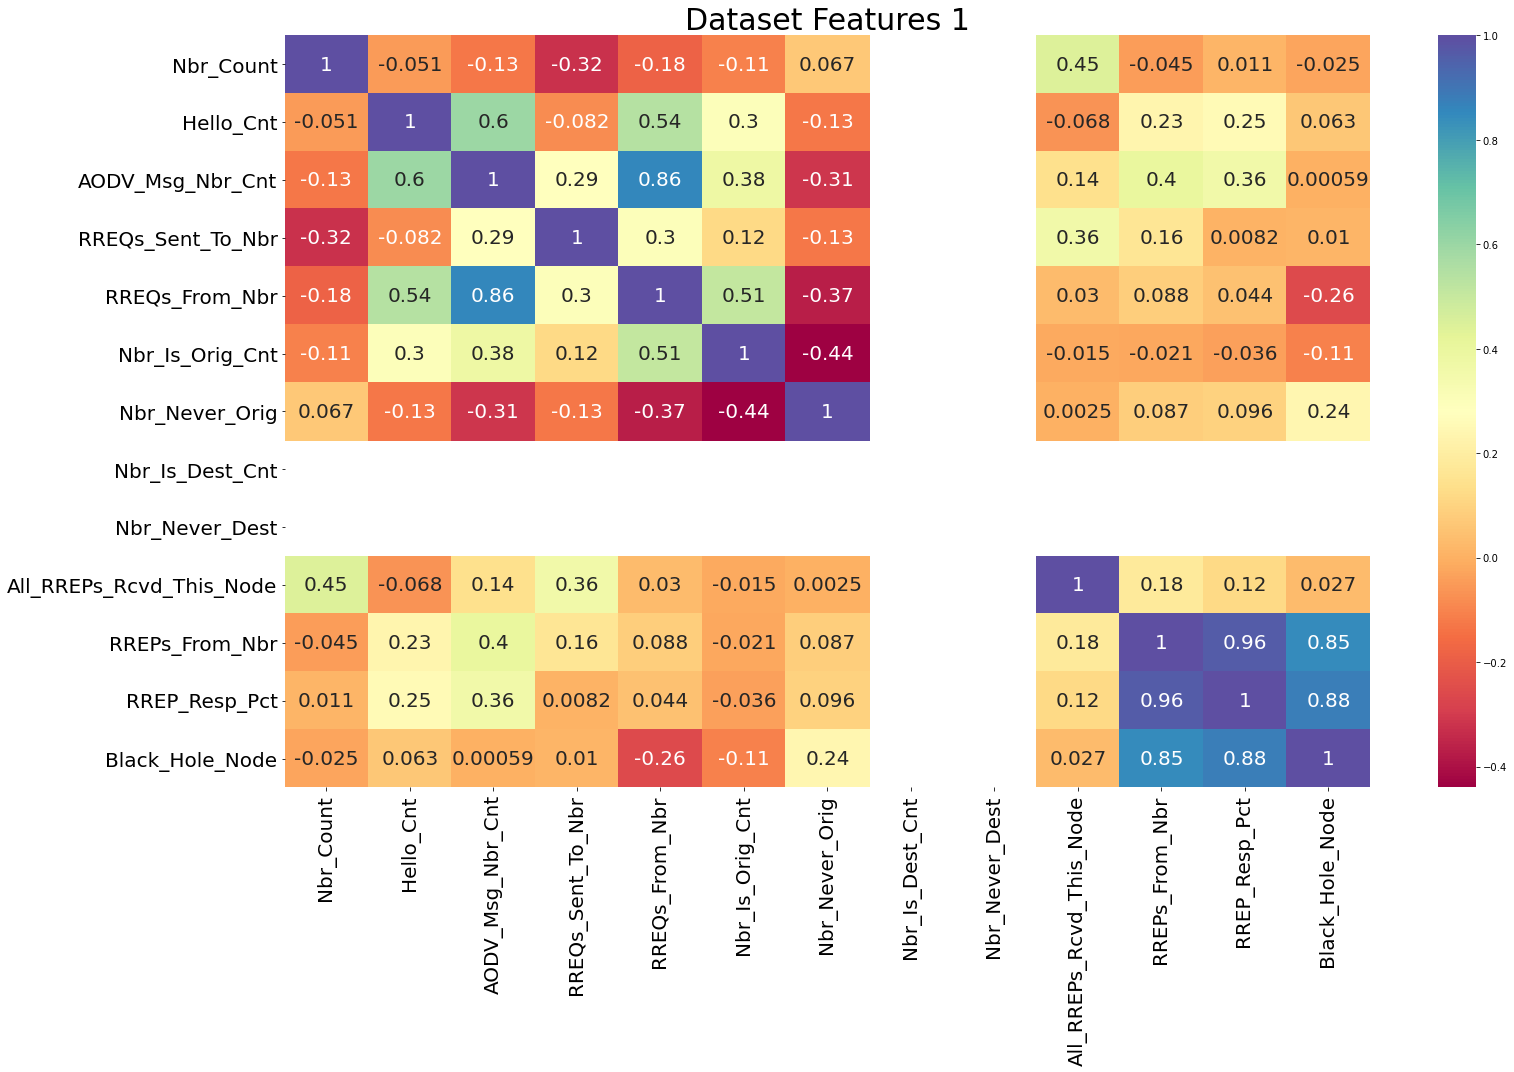

In [21]:
# Plot the 1st correlation Matrix
plt.rcParams["figure.figsize"] = [23, 15]
plt.rcParams["figure.autolayout"] = True
ax = sns.heatmap(train_cm1.corr(), annot=True, cmap='Spectral', annot_kws={'fontsize': 20})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 20)
ax.set_yticklabels(ax.get_xmajorticklabels(), fontsize = 20)
plt.title('Dataset Features 1', fontsize=30)
plt.show()

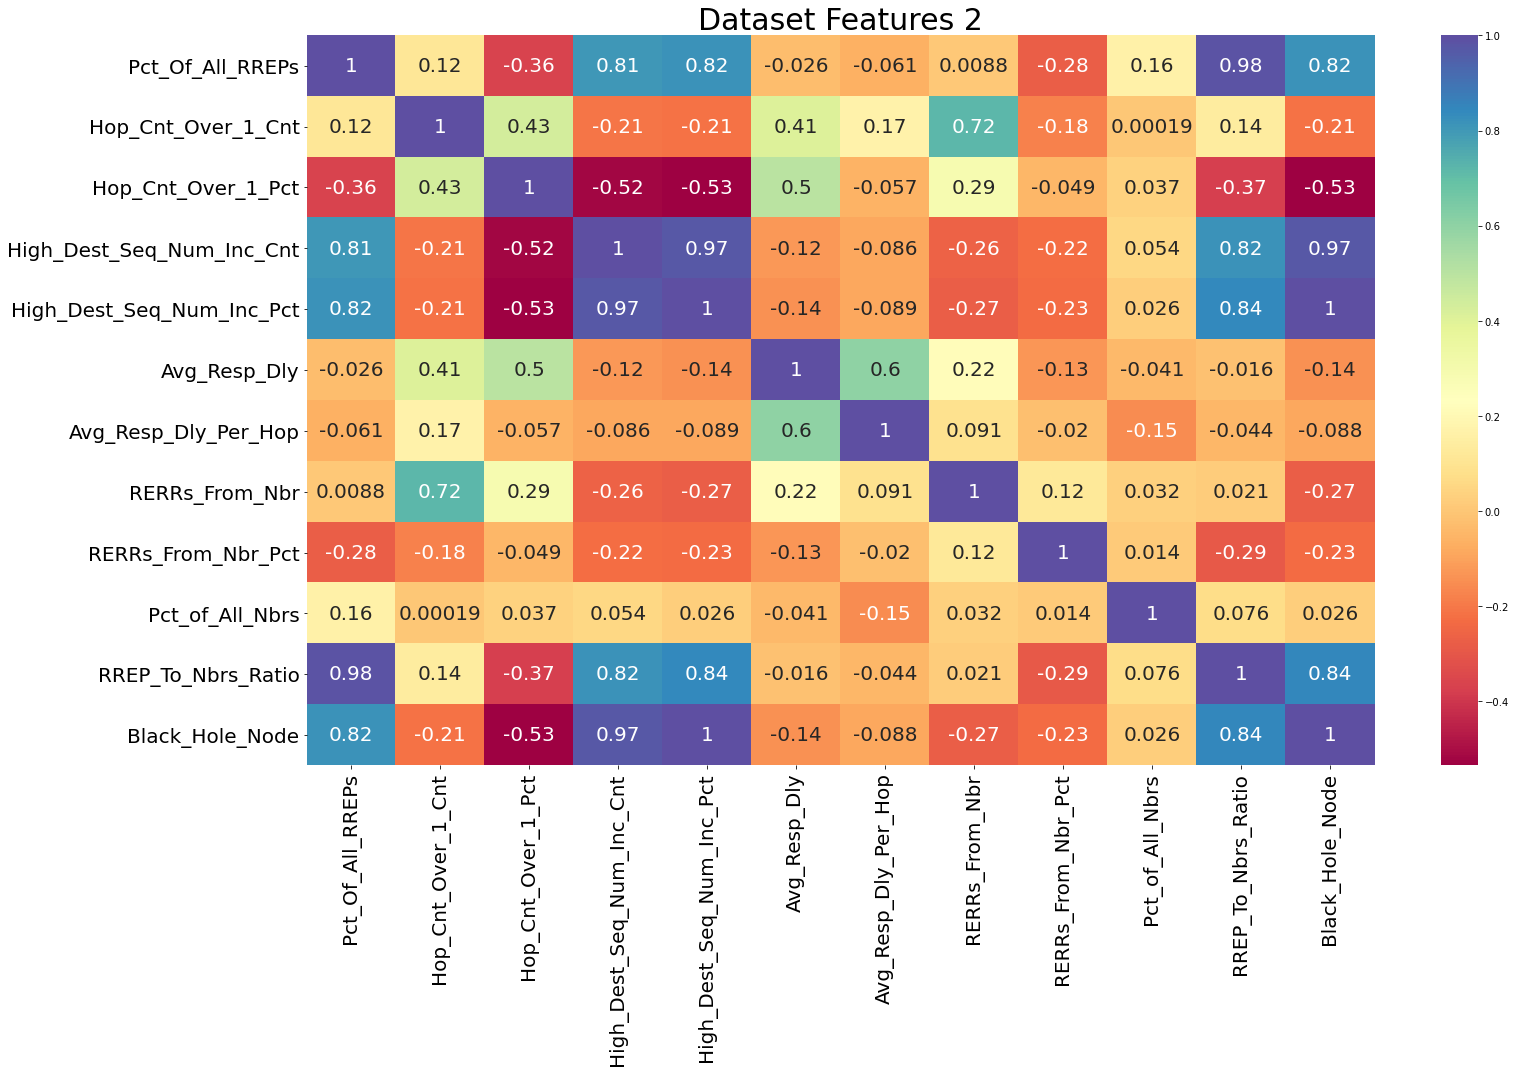

In [22]:
# Plot the 2nd correlation Matrix
plt.rcParams["figure.figsize"] = [23, 15]
plt.rcParams["figure.autolayout"] = True
ax = sns.heatmap(train_cm2.corr(), annot=True, cmap='Spectral', annot_kws={'fontsize': 20})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 20)
ax.set_yticklabels(ax.get_xmajorticklabels(), fontsize = 20)
plt.title('Dataset Features 2', fontsize=30)
plt.show()

The correlation heatmaps above show which features correlate the strongest with the target variable in the final column. It can be clearly seen that the following variables have a strong correlation to black hole nodes:

**Nbr_Never_Dest** - wait for sim files to be corrected
RREPs_From_Nbr
RREP_Resp_Pct
Pct_Of_All_RREPs
High_Dest_Seq_Num_Inc_Cnt
High_Dest_Seq_Num_Inc_Pct
RREP_To_Nbrs_Ratio

A reasonably strong correlation:
Hop_Cnt_Over_1_Pct



**Possibly remove some features with strong collinearity**

The feature that has the strongest correlation to the target variable will be the one that is retained. Note that the threshold of multicollinearity correlation for removal was set to 0.9 in the new data set to evaluate the results. 'mean compactness', 'XX' and 'YY' will not be removed. This dataset will be evaluated and compared to the original dataset in section B5.

'Nbr_Count' & 'Pct_Of_All_Nbrs'

'RREP_Resp_Pct' & 'RREPs_From_Nbr'

**Removal of features with absolute values**

These simulation were run for a time of approximately 200 seconds. There will be many different scenarios of real AODV networks and it is not possible to test for all the various different real-life configurations. One important considertion is the time of a simulation. The longer a simulation is run, the more messages it will generate. 

The model should not be trained for a simulation running for a specific amount of time but rather to detect a black hole node for a simulation of any amount of time. To do this, the percentage of all messages will be taken into consideration rather than the absolute values or counts. All features that have a absolute values, some of end with 'cnt' short for count will be removed from the training and test sets. This will also remove features that exhibit strong collinearity.

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Index                      413 non-null    int64  
 1   Node                       413 non-null    object 
 2   Nbr_Node                   413 non-null    object 
 3   Nbr_Count                  413 non-null    int64  
 4   Hello_Cnt                  413 non-null    int64  
 5   AODV_Msg_Nbr_Cnt           413 non-null    int64  
 6   RREQs_Sent_To_Nbr          413 non-null    int64  
 7   RREQs_From_Nbr             413 non-null    int64  
 8   Nbr_Is_Orig_Cnt            413 non-null    int64  
 9   Nbr_Never_Orig             413 non-null    int64  
 10  Nbr_Is_Dest_Cnt            413 non-null    int64  
 11  Nbr_Never_Dest             413 non-null    int64  
 12  All_RREPs_Rcvd_This_Node   413 non-null    int64  
 13  RREPs_From_Nbr             413 non-null    int64  

The pairplots below show the relationship between the selected features to each other and to the target variable.
A normal node is blue and a black hole node is brown.

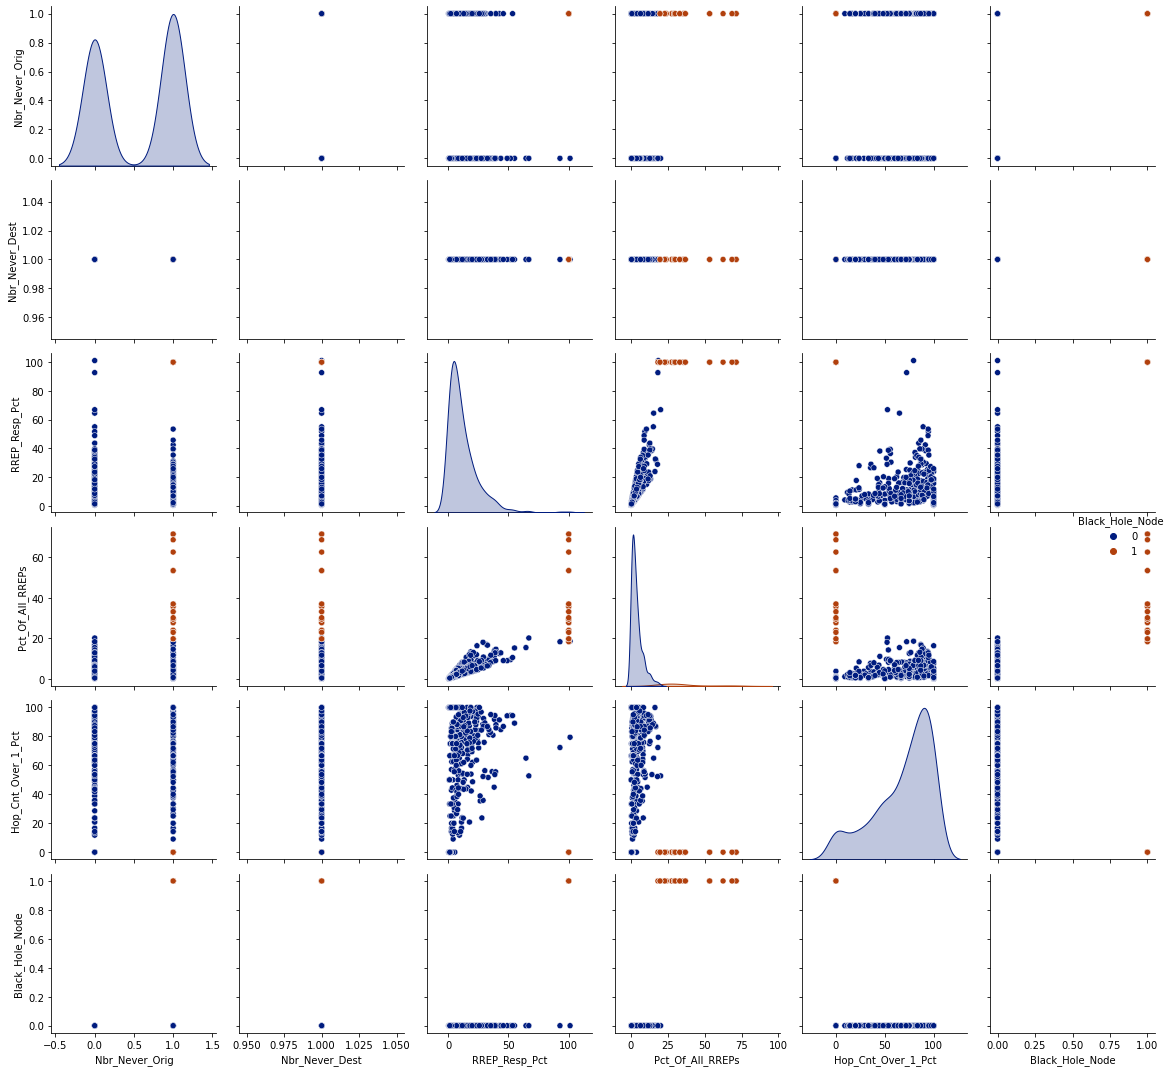

In [24]:
sns.pairplot(data=train, hue='Black_Hole_Node', palette='dark', 
     vars = ['Nbr_Never_Orig', 'Nbr_Never_Dest','RREP_Resp_Pct','Pct_Of_All_RREPs', 
              'Hop_Cnt_Over_1_Pct','Black_Hole_Node'])

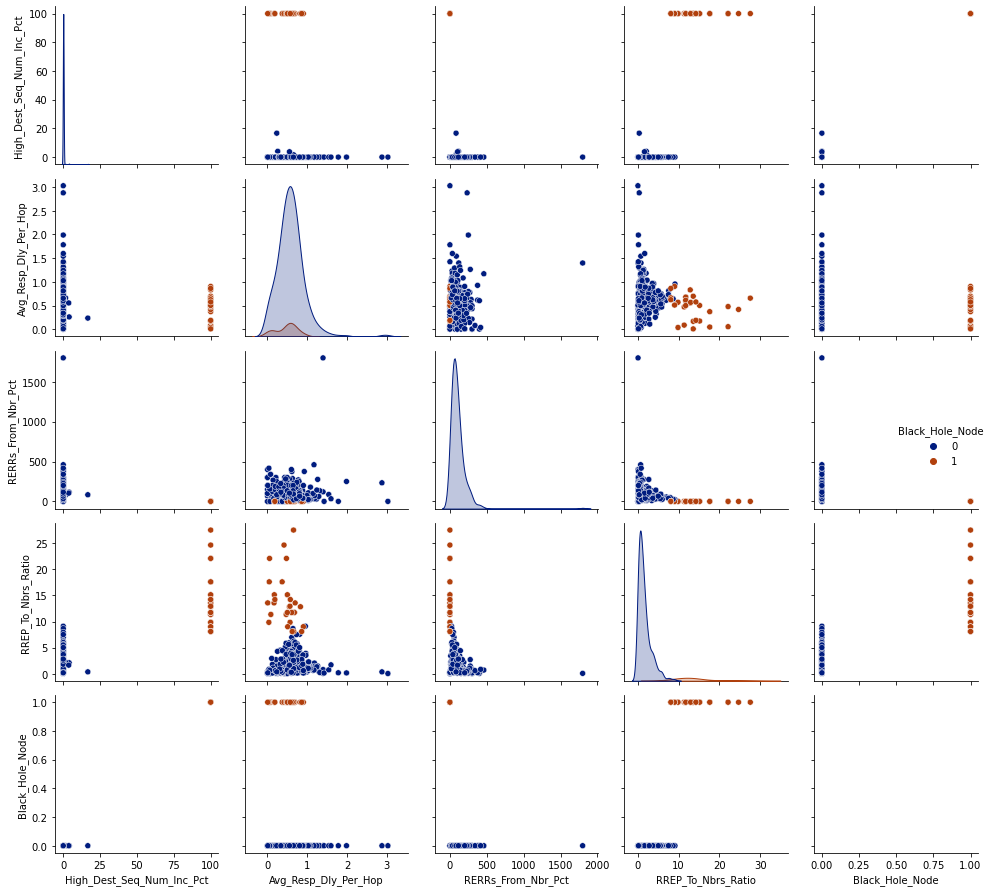

In [25]:
sns.pairplot(data=train, hue='Black_Hole_Node', palette='dark', 
     vars = ['High_Dest_Seq_Num_Inc_Pct','Avg_Resp_Dly_Per_Hop', 
             'RERRs_From_Nbr_Pct', 'RREP_To_Nbrs_Ratio', 'Black_Hole_Node'])

**Remove the unnecessary features and extract the target variable from the train and test sets**

<span style="color: red;">**Determine final list of which features need to be eliminated, maybe create new features**</span>

In [26]:
X_train = train[['Nbr_Never_Orig','Nbr_Never_Dest','RREP_Resp_Pct','Pct_Of_All_RREPs','Hop_Cnt_Over_1_Pct',
                 'High_Dest_Seq_Num_Inc_Pct','Avg_Resp_Dly_Per_Hop','RERRs_From_Nbr_Pct','RREP_To_Nbrs_Ratio']]
y_train = train[['Black_Hole_Node']]

X_test = test[['Nbr_Never_Orig','Nbr_Never_Dest','RREP_Resp_Pct','Pct_Of_All_RREPs','Hop_Cnt_Over_1_Pct',
                 'High_Dest_Seq_Num_Inc_Pct','Avg_Resp_Dly_Per_Hop','RERRs_From_Nbr_Pct','RREP_To_Nbrs_Ratio']]
y_test = test[['Black_Hole_Node']]

In [27]:
y_train.head()

,Black_Hole_Node
0,0
1,0
2,1
3,0
4,0


In [28]:
print(y_train['Black_Hole_Node'].value_counts())
print()
print(y_test['Black_Hole_Node'].value_counts())

0    383
1     30
Name: Black_Hole_Node, dtype: int64

0    204
1     10
Name: Black_Hole_Node, dtype: int64


In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Nbr_Never_Orig             413 non-null    int64  
 1   Nbr_Never_Dest             413 non-null    int64  
 2   RREP_Resp_Pct              413 non-null    float64
 3   Pct_Of_All_RREPs           413 non-null    float64
 4   Hop_Cnt_Over_1_Pct         413 non-null    float64
 5   High_Dest_Seq_Num_Inc_Pct  413 non-null    float64
 6   Avg_Resp_Dly_Per_Hop       413 non-null    float64
 7   RERRs_From_Nbr_Pct         413 non-null    float64
 8   RREP_To_Nbrs_Ratio         413 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 29.2 KB


In [30]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Nbr_Never_Orig             214 non-null    int64  
 1   Nbr_Never_Dest             214 non-null    int64  
 2   RREP_Resp_Pct              214 non-null    float64
 3   Pct_Of_All_RREPs           214 non-null    float64
 4   Hop_Cnt_Over_1_Pct         214 non-null    float64
 5   High_Dest_Seq_Num_Inc_Pct  214 non-null    float64
 6   Avg_Resp_Dly_Per_Hop       214 non-null    float64
 7   RERRs_From_Nbr_Pct         214 non-null    float64
 8   RREP_To_Nbrs_Ratio         214 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 15.2 KB


### Further Data Exploration

### Examine the imbalance of the target variable

Hyperparameters will be tuned by performing a grid search on various hyperparameter combinations in the training set to find the best combination of values.

The proportion of normal and malignant nodes are checked in both the training and test datasets.

In [31]:
print('For the training dataset:')
print('The number of normal neighbours are', (y_train['Black_Hole_Node'] == 0).sum(), \
'or', round(100*(y_train['Black_Hole_Node'] == 0).sum()/y_train.shape[0],1), '%')
print('The number of malignant neighbours are', (y_train['Black_Hole_Node'] == 1).sum(), \
'or', round(100*(y_train['Black_Hole_Node'] == 1).sum()/y_train.shape[0],1), '%')

For the training dataset:
The number of normal neighbours are 383 or 92.7 %
The number of malignant neighbours are 30 or 7.3 %


In [32]:
print('For the test dataset:')
print('The number of normal neighbours are', (y_test['Black_Hole_Node'] == 0).sum(), \
'or', round(100*(y_test['Black_Hole_Node'] == 0).sum()/y_test.shape[0],1), '%')
print('The number of malignant neighbours are', (y_train['Black_Hole_Node'] == 1).sum(), \
'or', round(100*(y_test['Black_Hole_Node'] == 1).sum()/y_test.shape[0],1), '%')

For the test dataset:
The number of normal neighbours are 204 or 95.3 %
The number of malignant neighbours are 30 or 4.7 %


Looking above, the split of the target variable cases between the training and test data sets is not perfect but the percentages are close and both are low. In the traib dataset, 92.7% of neighbour rows are normal nodes and 7.3% are malignant neighbours. This is a large imbalance but in the vast majority of AODV networks, it is expected that the number of black hole nodes will be 0 or very small.<br>
In many machine learning classification problems such as this, class imbalance occurs frequently. This tends to bias the algorithm towards the majority class.
**Think about expanding on this**

## Machine Learning Model Design

A Random Forest model and a Support Vector Machine model will be tuned, trained and evaluated to see how well they can predict if a neighbouring node is a black hole node.


## Model 1 - Black Hole Node detection using Random Forest Model

Write something here

In [33]:
# Create an instance of the random forest model with 500 trees in the forest.
from sklearn.ensemble import RandomForestClassifier
rfc1 = RandomForestClassifier(n_estimators=200, random_state=2)

In [34]:
# Display the model's parameters.
params = rfc1.get_params()
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}

**Set the hyperparameters for the grid search**

In [35]:
"""
params = {'criterion': ['gini', 'entropy', 'log_loss'], 
          'max_depth': range(1,10), 'max_features': ['sqrt', 'log2', 'None']}
"""

# A reduced set will be used for now to speed up the process
params = {'criterion': ['gini', 'entropy'], 
          'max_depth': range(1,6), 'max_features': ['sqrt', 'log2']}

In [36]:
# Define the grid search

# set up cross validation to split into 10 folds. 
# Repeat 3 times to reduce the randomness of the result.
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

grid1 = GridSearchCV(estimator=rfc1, param_grid=params, 
    cv=cv, scoring='accuracy', error_score=0)

**Determine the best hyperparameter settings by running the grid search**

In [37]:
# get the start time
st = time.time()

# Fit the grid search options to the training data.
grid1.fit(X_train, y_train)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print(str(round(elapsed_time,2)) + " seconds")

99.31 seconds


**Display the optimal values**

In [38]:
print("Best Hyper Parameters:", grid1.best_params_)

Best Hyper Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt'}


**Make a prediction and calculate metrics**<br>

In [39]:
# Summarize the results
print("Best: %f using %s" % (grid1.best_score_, grid1.best_params_))
means = grid1.cv_results_['mean_test_score']
stds = grid1.cv_results_['std_test_score']
params = grid1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# The first line of the output above shows the best combination
# of hyperparameters and their resulting accuracy in the training dataset.

Best: 0.998810 using {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt'}
0.997590 (0.007231) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt'}
0.997590 (0.007231) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2'}
0.998810 (0.005189) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt'}
0.998810 (0.005189) with: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2'}
0.998810 (0.005189) with: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt'}
0.998810 (0.005189) with: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2'}
0.998810 (0.005189) with: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt'}
0.998810 (0.005189) with: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2'}
0.998810 (0.005189) with: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt'}
0.998810 (0.005189) with: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2'}
0.997590 (0.007231) with: {'criterion

In [40]:
# Fit the best hyperparameters to the model.
rfc1 = grid1.best_estimator_

**Display the accuracy score of predicting the training set**

In [41]:
# Check the accuracy score on the training dataset.
score = rfc1.score(X_train, y_train)
print("Accuracy:",score)

Accuracy: 1.0


In [42]:
# Display the model's parameters.
params = rfc1.get_params()
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}

**Predict the classifications on the test set**

In [43]:
y_pred= rfc1.predict(X_test)

**Evaluate the model**

**Display accuracy, precision and recall on the test set**

In [44]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average = 'weighted'))
print("Recall:",metrics.recall_score(y_test, y_pred, average = 'weighted'))
print("F1-score:",metrics.f1_score(y_test, y_pred, average = 'weighted'))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


**Display the classification report for rfc1**

In [45]:
targ_names = ('Normal', 'Black Hole')
class_report_RF = classification_report(y_test, y_pred, target_names = targ_names)
print(class_report_RF)

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       204
  Black Hole       1.00      1.00      1.00        10

    accuracy                           1.00       214
   macro avg       1.00      1.00      1.00       214
weighted avg       1.00      1.00      1.00       214



**Confusion matrix visualization**

A confusion matrix will provide visual information on the model's accuracy.

Text(70.30000000000003, 0.5, 'Predicted label')

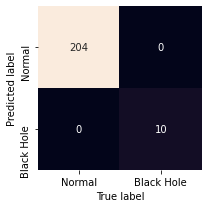

In [46]:
cm1 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,3))

sns.heatmap(cm1.T, square=True, annot=True, fmt='d', cbar=False,
xticklabels=targ_names,
yticklabels=targ_names)
plt.xlabel('True label')
plt.ylabel('Predicted label')

In [47]:
# Compile a list of actual black hole nodes and predicted black hole nodes
test_BHNs = []
predicted_BHNs = []
for idx in range(len(test)):
    if test['Black_Hole_Node'][idx] == 1:
        if not test['Nbr_Node'][idx] in test_BHNs:
            test_BHNs.append(test['Nbr_Node'][idx])
    if y_pred[idx] == 1:
        if not test['Nbr_Node'][idx] in predicted_BHNs:
            predicted_BHNs.append(test['Nbr_Node'][idx])

In [48]:
# Display the simulated and predicted black hole nodes
print('For the tuned Random Forest Classifier')
print('Simulated Black Hole Nodes')
print(test_BHNs)
print()
print('Predicted Black Hole Nodes')
print(predicted_BHNs)

For the tuned Random Forest Classifier
Simulated Black Hole Nodes
['10.1.1.45', '10.1.1.49']

Predicted Black Hole Nodes
['10.1.1.45', '10.1.1.49']


The output above confirms the confusion matrix results that the Random Forest model accurately predicts all of the simulated black hole nodes.

### Evaluation of Model 1, Random Forest with grid search
Write something on its accuracy and performance. Check for overfitting.

#### Save the trained random forest model
The best DTC model will be saved in the working directory as follows:

In [49]:
with open('rfc_1_model', 'wb') as f:
    pickle.dump(rfc1,f)
    f.close()

### Model 2 - Black Hole Node detection using Support Vector Machine Model

Standardization
Standardization is a feature scaling process of subtracting the mean value from each feature and then dividing the difference by the feature's standard deviation [18]. Distance algorithms including SVM are adversely affected by the difference in the range of features [19]. They use distances between data points to determine their similarity. For example, looking at the output of train.describe() above in section B1 the feature 'RREQs_Sent_To_Nbr' has a mean value of 203.6 and a standard deviation of 50.18. Further on, the feature 'Avg_Resp_Dly_Per_Hop' has a mean value of 0.578 and a standard deviation of 0.345. As both features have vastly different scales, more weight in the algorithm will be given to 'RREQs_Sent_To_Nbr'. This will bias the performance of the SVM algorithm towards 'RREQs_Sent_To_Nbr' Ideally, all features should be treated with equal weight. To achieve this, all features will be scaled so that they all have a similar magnitude.
Tree based algorithms are not affected by the difference in scale of the features. A decision tree only splits a node based on a single feature.
Instead of directly invoking a scale function, a Scikit-Learn feature called the Transformer API will be used [18].

In [50]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)

The scaler object now has the saved means and standard deviations for each feature in the training set. The result will be displayed

In [51]:
X_train_scaled = scaler.transform(X_train)

In [52]:
# Display the mean value of each feature after scaling.
print(X_train_scaled.mean(axis=0))

[-3.87099553e-17  0.00000000e+00  1.11828760e-16  7.74199107e-17
 -2.17205861e-16  6.98929749e-17 -2.58066369e-17  1.07527654e-17
 -9.03232291e-17]


The output above shows that the mean value of each feature is now effectively 0.

In [53]:
# Display the standard deviation of each feature after scaling.
print(X_train_scaled.std(axis=0))

[1. 0. 1. 1. 1. 1. 1. 1. 1.]


The output above shows that the standard deviation of each feature is now 1.

<span style="color: red;">**Finalize the final features and ensure no 0s above**</span>

Next, the same scaler object is used to transform the test set using the exact same means and standard deviations used to transform the training set. If the test set was scaled separately, it would not be a fair evaluation of the model.

In [54]:
X_test_scaled = scaler.transform(X_test)

In [55]:
# Display the mean value of each feature in the test set after scaling.
print(X_test_scaled.mean(axis=0))

[-0.05527006  0.         -0.06200943  0.03495215  0.18641875 -0.09880989
  0.02356761  0.06416391 -0.00586498]


The mean values of the features of the test set are now close to 0 but are not perfectly centred.  This is expected, the test set is transformed using the means from the training set.

In [56]:
# Display the standard deviation of each feature in the test set after scaling.
print(X_test_scaled.std(axis=0))

[1.00725475 0.         0.86508072 1.13092612 0.89226847 0.81337332
 0.94225061 1.16991799 1.14420327]


The standard deviation of each feature in the test set is now close to 1 as is expected.

### Parameter Tuning
Cross validation will also be performed for the svm model with standardized data to find the optimum settings for the hyperparameters. <span style="color: red;">This is done using the same method as was described for the random forest model.</span>

In [57]:
# Create an instance of the model.
svc = SVC()

**Parameters setup:**<br>
Four kernels are chosen and various hyperparameters pertaining to them will be tested to determine what is the optimum combination of settings for this dataset.

In [58]:
"""
param_grid = [{'C': [0.0, 0.1, 0.5, 1, 5, 10], 
               'kernel': ['linear'], 'class_weight': ['balanced']},
  {'C': [0.0, 0.1, 0.5, 1, 5, 10], 'kernel': ['rbf'],
   'gamma': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
   'class_weight': ['balanced']},        
{'C': [0.0, 0.1, 0.5, 1, 5, 10], 'kernel': ['poly'], 
 'gamma': ['scale', 0, 0.00001, 0.0001, 0.0005, 0.001, 0.01, 0.1, 0.005, 0.05, 0.5], 
 'degree': [1,2,3,4,5,6], 'coef0': [0.0, 0.1, 0.5, 1, 5, 10], 
 'class_weight': ['balanced'], 'max_iter': [10000]},
 {'C': [0.0, 0.1, 0.5, 1, 5, 10], 'kernel': ['sigmoid'],
  'gamma': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
  'coef0': [0.0, 0.1, 0.5, 1, 5, 10], 'class_weight': ['balanced']} ]
"""
# A reduced set will be used for now to speed up the process
param_grid = [{'C': [0.0, 0.1, 0.5, 1], 
               'kernel': ['linear'], 'class_weight': ['balanced']},
  {'C': [0.0, 0.1, 0.5, 1, 5, 10], 'kernel': ['rbf'],
   'gamma': [0.01, 0.05, 0.1, 0.5, 1],
   'class_weight': ['balanced']},        
{'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['poly'], 
 'gamma': ['scale', 0.01, 0.1, 0.005, 0.05, 0.5], 
 'degree': [1,2,3,4], 'coef0': [0.1, 0.5, 1, 5, 10], 
 'class_weight': ['balanced'], 'max_iter': [1000]}
 ]


In [59]:
# Define the grid search

# set up cross validation to split into 10 folds. Repeat 2 times
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

# Load the model and all parameters into the grid search.
grid2 = GridSearchCV(estimator=svc, param_grid=param_grid, cv=cv, 
                    scoring='accuracy', error_score=0)

In [60]:
# get the start time
st = time.time()

# Test and fit the grid search options to the training data.
grid2.fit(X_train_scaled, y_train)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print(str(round(elapsed_time,2)) + " seconds")

29.0 seconds


**Display the best hyperparameter settings**

In [61]:
print("Best Hyper Parameters:", grid2.best_params_)

Best Hyper Parameters: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}


**Make a prediction and calculate metrics**

In [62]:
svc_1 = grid2.best_estimator_

In [63]:
# Summarize the results
print("Best: %f using %s" % (grid2.best_score_, grid2.best_params_))
means = grid2.cv_results_['mean_test_score']
stds = grid2.cv_results_['std_test_score']
params = grid2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# The first line of the output above shows 
# the best combination of hyperparameters and 
# their resulting accuracy in the training dataset.

Best: 1.000000 using {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 0.0, 'class_weight': 'balanced', 'kernel': 'linear'}
1.000000 (0.000000) with: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
1.000000 (0.000000) with: {'C': 0.5, 'class_weight': 'balanced', 'kernel': 'linear'}
1.000000 (0.000000) with: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 0.0, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 0.0, 'class_weight': 'balanced', 'gamma': 0.05, 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 0.0, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 0.0, 'class_weight': 'balanced', 'gamma': 0.5, 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 0.0, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
1.000000 (0.000000) with: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}
0.998

**Display the accuracy score of predicting on the training set**

In [64]:
score = svc_1.score(X_train_scaled,y_train)
print("Accuracy:",score)

Accuracy: 1.0


**Predict the classifications on the test set**

In [65]:
y_pred_2=svc_1.predict(X_test_scaled)

**Display the classification report of svc_1**

In [66]:
print(classification_report(y_test, y_pred_2, target_names=targ_names))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       204
  Black Hole       1.00      1.00      1.00        10

    accuracy                           1.00       214
   macro avg       1.00      1.00      1.00       214
weighted avg       1.00      1.00      1.00       214



**Evaluate the model**

In [67]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_2))
print("Precision:",metrics.precision_score(y_test, y_pred_2, average = 'weighted'))
print("Recall:",metrics.recall_score(y_test, y_pred_2, average = 'weighted'))
print("F1-score:",metrics.f1_score(y_test, y_pred_2, average = 'weighted'))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


**Create a confusion Matrix**

In [68]:
cm2 = confusion_matrix(y_test, y_pred_2)

Text(70.30000000000003, 0.5, 'Predicted label')

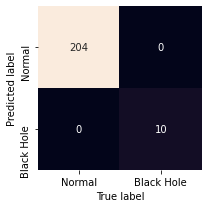

In [69]:
plt.figure(figsize=(5,3))

sns.heatmap(cm2.T, square=True, annot=True, fmt='d', cbar=False,
xticklabels=targ_names,
yticklabels=targ_names)
plt.xlabel('True label')
plt.ylabel('Predicted label')

In [70]:

# Compile a list of actual black hole nodes and predicted black hole nodes
test_BHNs = []
predicted_BHNs = []
for idx in range(len(test)):
    if test['Black_Hole_Node'][idx] == 1:
        if not test['Nbr_Node'][idx] in test_BHNs:
            test_BHNs.append(test['Nbr_Node'][idx])
    if y_pred_2[idx] == 1:
        if not test['Nbr_Node'][idx] in predicted_BHNs:
            predicted_BHNs.append(test['Nbr_Node'][idx])


In [71]:
# Display the simulated and predicted black hole nodes
print('For the tuned Support Vector Machine Classifier')
print('Simulated Black Hole Nodes')
print(test_BHNs)
print()
print('Predicted Black Hole Nodes')
print(predicted_BHNs)

For the tuned Support Vector Machine Classifier
Simulated Black Hole Nodes
['10.1.1.45', '10.1.1.49']

Predicted Black Hole Nodes
['10.1.1.45', '10.1.1.49']


The output above confirms the confusion matrix results that the SVM model accurately predicts all of the simulated black hole nodes.

### Evaluation of Model 2 
### Support Vector Machine using standardized dataset with tuned hyperparameters

<span style="color: red;">**Write a proper summary once the final dataset has been used.**</span>

### Save the support vector machine model
The model will be saved in the working directory as follows. It can now be loaded and applied without having to be refitted.

In [72]:
with open('svc_1', 'wb') as f:
    pickle.dump(svc_1,f)
    f.close()

## <span style="color: darkblue;">Machine Learning Conclusion</span>
<span style="color: red;">**Write a proper summary once the final dataset has been used.**</span>

## Further Work
<span style="color: red;">**Write a proper summary once the final dataset has been used.**</span>

Write about the simulation results still having several issues which need to be addressed so that it accurately simulates AODV protocol.

**Variance Bias Tradeoff?**

Other models like CNN.

Placing the ML algorithms back into the NS-3 simulator so that the individual nodes can learn to detect if a 1st tier neighbour is a black hole node.

I am expecting the accuracy of detection to be very high if the simulation is working as expected. 

Talk about measuring the degradation of network performance. Larger datasets could be trained with vastly different network confogiurations including, number of nodes, size of network, mobility of nodes, RF network coverge conditions, number of black hole nodes, possibly making black hole nodes more intelligent.